### Convert to Binary Image:
Use image processing software (e.g., ImageJ, Python, MATLAB) to threshold the image and create a binary mask where pores are white (1) and the polymer film is black (0).

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

image_path = 'sample2A.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image (thresholding to highlight pores)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

# Find contours of the pores
contours = measure.find_contours(binary_image, 0.8)

# Extract centroids of the pores
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])  # X-coordinate of centroid
        cy = int(M["m01"] / M["m00"])  # Y-coordinate of centroid
        centroids.append((cx, cy))

centroids = np.array(centroids)

In [3]:
print(centroids)

[[0 2]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 0]
 [0 0]]


 ## Extract Droplet Centroids

[[924, 148], [432, 132], [157, 111], [996, 141], [1487, 153], [1220, 212], [251, 307], [842, 360], [584, 338], [1652, 371], [1363, 399], [1106, 404], [1453, 373], [400, 494], [124, 509], [680, 549], [1795, 541], [1511, 617], [966, 641], [1248, 624], [527, 699], [289, 734], [1742, 759], [744, 761], [1164, 819], [1132, 764], [1393, 856], [827, 780], [1083, 813], [915, 928], [428, 891], [90, 851], [1153, 880], [654, 975], [1607, 960], [242, 961], [1781, 1009], [78, 999], [1199, 1086], [420, 1136], [1454, 1089], [1650, 1186], [146, 1200], [922, 1206], [681, 1220], [1423, 1266], [1135, 1300], [510, 1306]]
Number of pores detected: 48


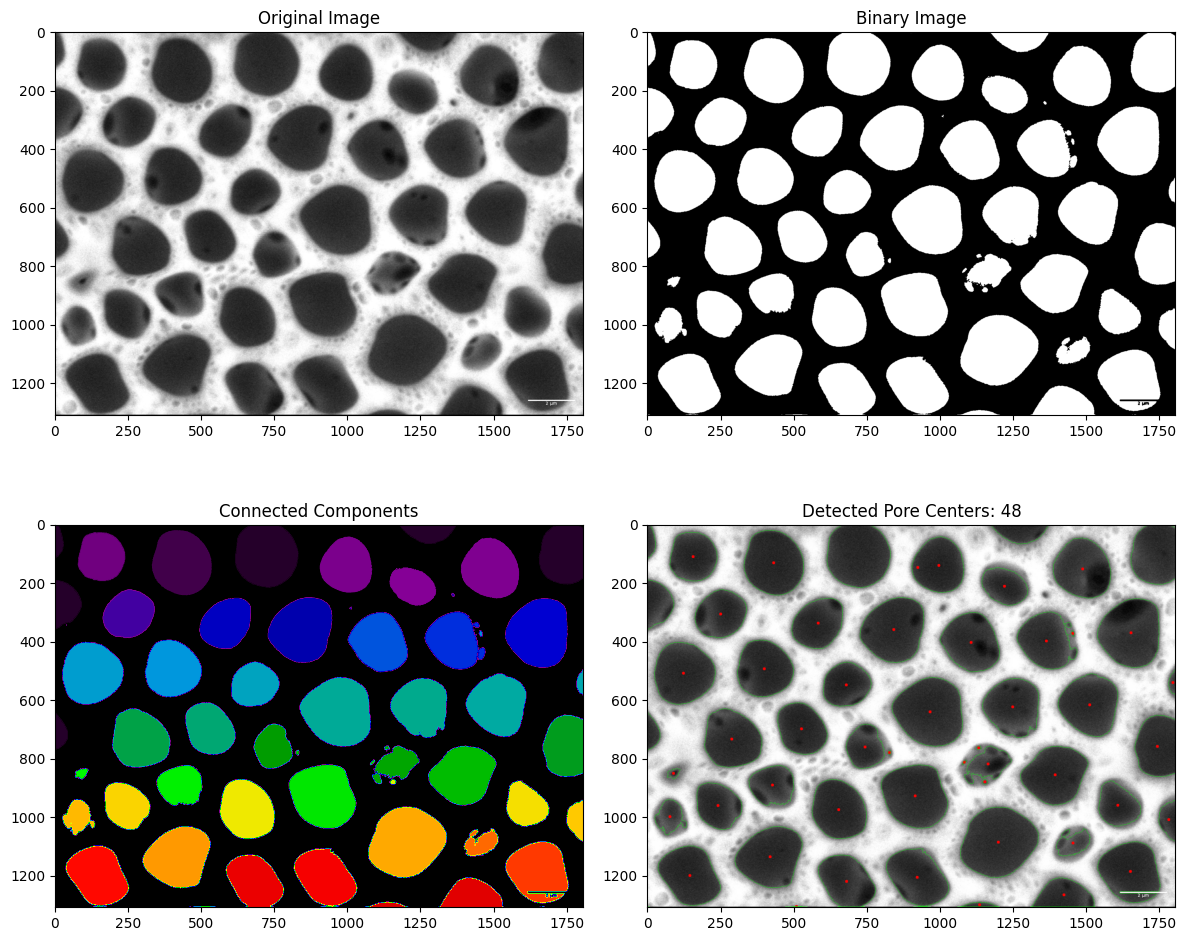

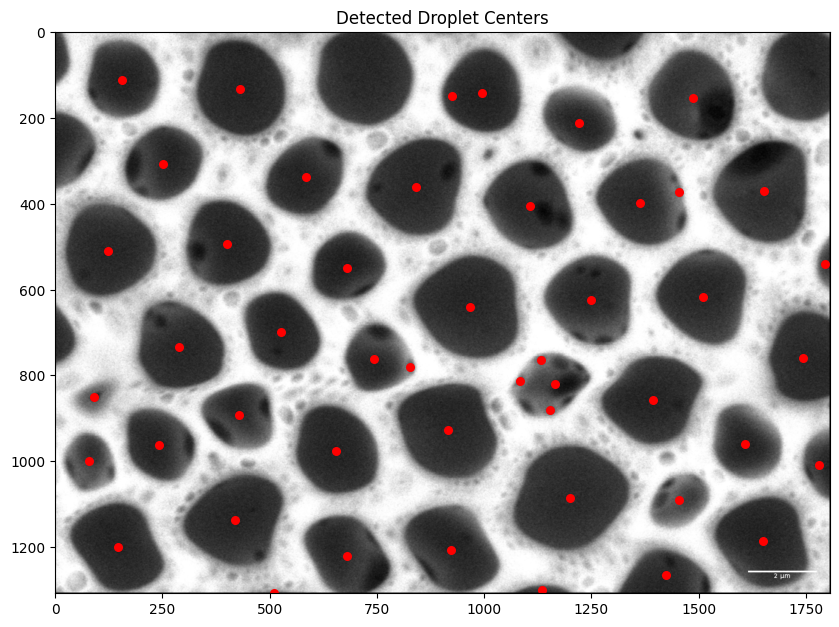

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "sample10A.png"  # Update with your image path if needed
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Apply binary threshold - simpler approach that works better for this image
# The black pores are already dark, so use a direct threshold
_, binary = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY_INV)

# Find connected components (black regions)
nb_components, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

# Filter components by size
min_size = 100  # Minimum area to consider
max_size = 100000  # Maximum area to consider (to filter out background)

# Create output image for visualization
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Filter components and draw their centers
filtered_centroids = []
for i in range(1, nb_components):  # Skip first component (background)
    area = stats[i, cv2.CC_STAT_AREA]
    if min_size < area < max_size:
        # Get center coordinates
        cx = int(centroids[i, 0])
        cy = int(centroids[i, 1])
        
        # Calculate average intensity in the original image for this component
        component_mask = (labels == i).astype(np.uint8)
        mean_intensity = cv2.mean(image, mask=component_mask)[0]
        
        # Only keep dark components (pores are dark)
        if mean_intensity < 100:  # Adjust this threshold as needed
            filtered_centroids.append([cx, cy])
            
            # Draw a red dot at the center
            cv2.circle(output_image, (cx, cy), 5, (0, 0, 255), -1)
            
            # Optional: Draw the component boundary for visualization
            contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(output_image, contours, -1, (0, 255, 0), 1)

# Convert to NumPy array
print(filtered_centroids)
filtered_centroids = np.array(filtered_centroids)
print(f"Number of pores detected: {len(filtered_centroids)}")

# Display the result
plt.figure(figsize=(12, 10))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

# Binary image
plt.subplot(2, 2, 2)
plt.imshow(binary, cmap='gray')
plt.title('Binary Image')

# Labeled components (color-coded)
plt.subplot(2, 2, 3)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Connected Components')

# Final result with centers
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title(f'Detected Pore Centers: {len(filtered_centroids)}')

plt.tight_layout()
plt.savefig('improved_pore_detection.png', dpi=300)
plt.show()

# Save the results
np.save('pore_centroids.npy', filtered_centroids)
cv2.imwrite('pore_centers.png', output_image)

# Also create a simple visualization showing just the original image with centers
plt.figure(figsize=(10, 8))
plt.imshow(image, cmap='gray')
plt.scatter(filtered_centroids[:, 0], filtered_centroids[:, 1], c='red', s=30)
plt.title('Detected Droplet Centers')
plt.savefig('droplet_centers.png', dpi=300)
plt.show()

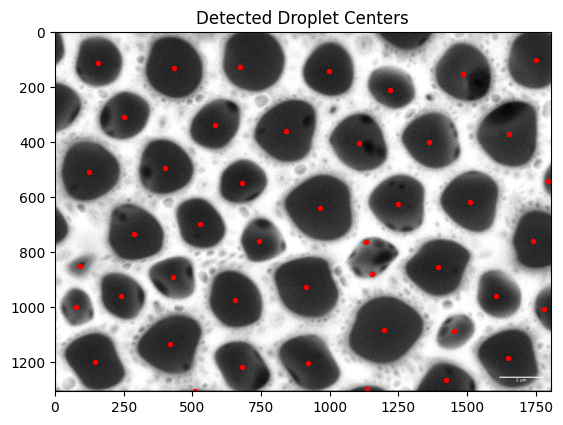

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
image_path = "sample10A.png"  # Update with your image path if needed
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply median blur to reduce noise
blurred = cv2.medianBlur(image, 5)

# Use Otsu's thresholding to create a binary mask
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Perform morphological closing to fill small gaps
kernel = np.ones((5, 5), np.uint8)
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

# Detect edges using Canny edge detector
edges = cv2.Canny(closed, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert to color image for visualization
output_final = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw detected pore centers
centroids = []
for cnt in contours:
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centroids.append([cx, cy])
# Convert to NumPy array
centroids =np.array([[432, 132], [157, 111], [996, 141], [1487, 153], [1220, 212], [251, 307], [842, 360], [584, 338], [1652, 371], [1363, 399], [1106, 404], [400, 494], [124, 509], [680, 549], [1795, 541], [1511, 617], [966, 641], [1248, 624], [527, 699], [289, 734], [1742, 759], [744, 761], [1132, 764], [1393, 856], [915, 928], [428, 891], [90, 851], [1153, 880], [654, 975], [1607, 960], [242, 961], [1781, 1009], [78, 999], [1199, 1086], [420, 1136], [1454, 1089], [1650, 1186], [146, 1200], [922, 1206], [681, 1220], [1423, 1266], [1135, 1300], [510, 1306],[675,125],[1750,100]]
)

# Step 5: Plot the results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=8)
plt.title('Detected Droplet Centers')
plt.show()

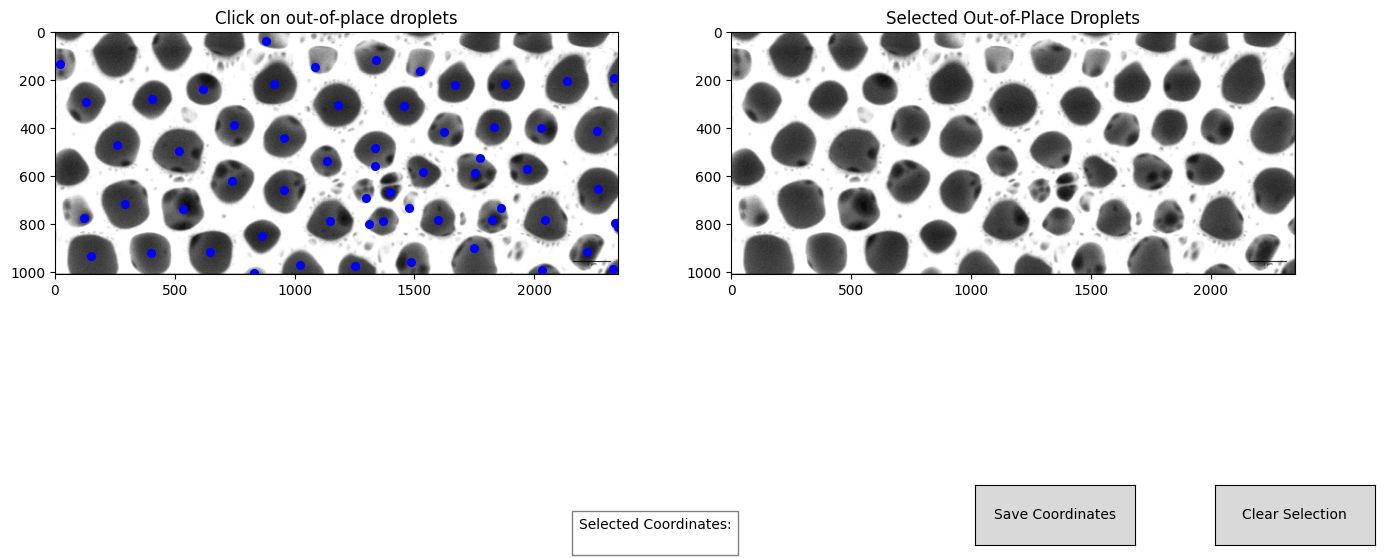


Final Selected Coordinates:


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

# Load the image in grayscale
image_path = "sample6A.png"  # Update with your image path if needed
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Detected droplet centers
centroids = np.array([
    [881, 36], [1338, 115], [23, 132], [2334, 191], [2137, 202], [1878, 214], [1084, 146],
    [916, 217], [1522, 162], [1671, 218], [619, 236], [405, 277], [130, 290], [1179, 303],
    [1456, 307], [749, 385], [2263, 411], [1831, 393], [2027, 399], [1625, 416], [955, 439],
    [259, 470], [516, 494], [1335, 484], [1134, 536], [1971, 569], [1753, 589], [1535, 581],
    [1774, 525], [737, 620], [1335, 558], [2266, 653], [955, 658], [292, 717], [1397, 667],
    [534, 737], [1297, 690], [2046, 782], [1599, 782], [1148, 789], [1860, 734], [1477, 731],
    [1367, 786], [1825, 784], [122, 774], [2350, 813], [1312, 798], [862, 848], [2335, 794],
    [649, 917], [402, 922], [152, 933], [2221, 918], [1486, 958], [1024, 972], [1254, 976],
    [2330, 987], [2033, 992], [831, 1006], [1750, 900]
])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.subplots_adjust(bottom=0.2)  # Make room for the buttons

# Display the image on the left subplot
ax1.imshow(image, cmap='gray')
scatter = ax1.scatter(centroids[:, 0], centroids[:, 1], c='blue', s=30)
ax1.set_title("Click on out-of-place droplets")

# Initialize variables for selected points
selected_indices = []
selected_coords = []

# Create a second plot to show selected droplets
ax2.imshow(image, cmap='gray')
selected_scatter = ax2.scatter([], [], c='red', s=50)
ax2.set_title("Selected Out-of-Place Droplets")

# Text annotation for coordinates
text_box = plt.figtext(0.5, 0.05, "Selected Coordinates:\n", ha="center", fontsize=10, 
                      bbox={"facecolor":"white", "alpha":0.5, "pad":5})

# Function to find the nearest centroid to a click
def find_nearest_centroid(x, y):
    distances = np.sqrt((centroids[:, 0] - x)**2 + (centroids[:, 1] - y)**2)
    nearest_idx = np.argmin(distances)
    # Only select if within a reasonable distance (e.g., 20 pixels)
    if distances[nearest_idx] < 20:
        return nearest_idx
    return None

# Click event handler
def on_click(event):
    if event.inaxes == ax1:
        idx = find_nearest_centroid(event.xdata, event.ydata)
        if idx is not None:
            # Toggle selection
            if idx in selected_indices:
                selected_indices.remove(idx)
                selected_coords.remove(centroids[idx].tolist())
            else:
                selected_indices.append(idx)
                selected_coords.append(centroids[idx].tolist())
            
            # Update the plots
            update_plots()

# Function to update plots and text
def update_plots():
    # Update the selected points plot
    if selected_indices:
        selected_points = centroids[selected_indices]
        selected_scatter.set_offsets(selected_points)
    else:
        selected_scatter.set_offsets(np.empty((0, 2)))
    
    # Update the text box with coordinates
    coord_text = "Selected Coordinates:\n"
    for i, coord in enumerate(selected_coords):
        coord_text += f"{i+1}: ({coord[0]}, {coord[1]})\n"
    
    text_box.set_text(coord_text)
    
    # Redraw the figure
    fig.canvas.draw_idle()

# Button to save coordinates
save_ax = plt.axes([0.7, 0.05, 0.1, 0.075])
save_button = Button(save_ax, 'Save Coordinates')

def save_coordinates(event):
    if selected_coords:
        np.savetxt('out_of_place_droplets.csv', np.array(selected_coords), 
                  delimiter=',', header='x,y', comments='', fmt='%d')
        print(f"Saved {len(selected_coords)} coordinates to out_of_place_droplets.csv")
    else:
        print("No droplets selected")

save_button.on_clicked(save_coordinates)

# Button to clear selection
clear_ax = plt.axes([0.85, 0.05, 0.1, 0.075])
clear_button = Button(clear_ax, 'Clear Selection')

def clear_selection(event):
    global selected_indices, selected_coords
    selected_indices = []
    selected_coords = []
    update_plots()
    print("Selection cleared")

clear_button.on_clicked(clear_selection)

# Connect the click event
fig.canvas.mpl_connect('button_press_event', on_click)

# Annotation for hovering
hover_annot = ax1.annotate("", xy=(0,0), xytext=(10,10), textcoords="offset points",
                     bbox=dict(boxstyle="round", fc="w"), color='black', ha='center', fontsize=9)
hover_annot.set_visible(False)

def update_hover_annotation(event):
    if event.inaxes == ax1:
        idx = find_nearest_centroid(event.xdata, event.ydata)
        if idx is not None:
            cx, cy = centroids[idx]
            hover_annot.xy = (cx, cy)
            hover_annot.set_text(f'({cx}, {cy})')
            hover_annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            hover_annot.set_visible(False)
            fig.canvas.draw_idle()

# Connect hover event
fig.canvas.mpl_connect("motion_notify_event", update_hover_annotation)

plt.show()

# After closing the plot, print the final selected coordinates
print("\nFinal Selected Coordinates:")
for i, coord in enumerate(selected_coords):
    print(f"{i+1}: ({coord[0]}, {coord[1]})")

# Also return the array of selected coordinates for further use
selected_array = np.array(selected_coords)
if len(selected_array) > 0:
    print("\nSelected coordinates as NumPy array:")
    print(selected_array)

[[2078 1534]
 [1444 1518]
 [1757 1527]
 [ 499 1512]
 [1308 1524]
 [ 287 1524]
 [ 129 1503]
 [1623 1500]
 [  83 1514]
 [1628 1481]
 [1412 1483]
 [1903 1485]
 [ 163 1468]
 [1414 1465]
 [1415 1451]
 [ 141 1441]
 [ 114 1438]
 [ 927 1468]
 [ 719 1475]
 [1117 1466]
 [1615 1383]
 [1640 1382]
 [1990 1440]
 [1562 1344]
 [  41 1348]
 [1524 1441]
 [1301 1391]
 [ 788 1333]
 [ 703 1318]
 [ 465 1403]
 [1767 1380]
 [ 987 1345]
 [ 850 1330]
 [ 290 1253]
 [ 242 1233]
 [ 173 1227]
 [ 185 1334]
 [ 224 1227]
 [ 208 1224]
 [ 270 1221]
 [ 785 1208]
 [ 160 1198]
 [ 163 1194]
 [ 234 1180]
 [ 211 1177]
 [ 787 1173]
 [ 258 1166]
 [1118 1241]
 [ 782 1162]
 [ 259 1161]
 [2069 1223]
 [1520 1210]
 [1912 1223]
 [ 268 1127]
 [ 664 1216]
 [1326 1199]
 [ 231 1142]
 [1827 1105]
 [ 388 1178]
 [1841 1104]
 [1816 1104]
 [ 688 1103]
 [1706 1174]
 [1460 1101]
 [1805 1094]
 [1856 1092]
 [1410 1095]
 [1586 1090]
 [1387 1082]
 [ 110 1120]
 [1854 1071]
 [ 910 1149]
 [  10 1067]
 [ 789 1064]
 [1828 1081]
 [ 807 1039]
 [1541 1033]

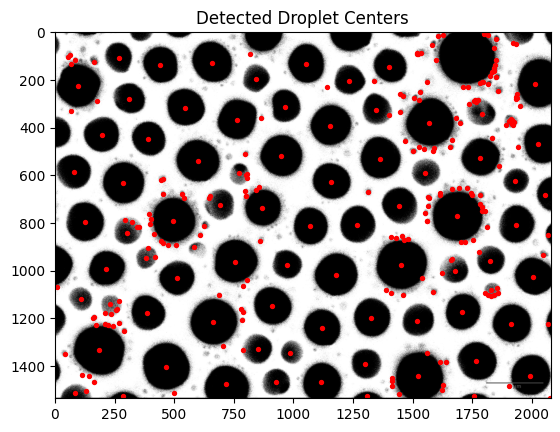

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "sample2A.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to smooth the image
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Apply thresholding to create a binary image
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the image to draw on
output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Calculate and draw centroids
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append((cX, cY))
        cv2.circle(output, (cX, cY), 3, (0, 0, 255), -1)

# Show the output image with centroids
centroids = np.array(centroids)



print(centroids)
# Convert to NumPy array
# Step 5: Plot the results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=8)
plt.title('Detected Droplet Centers')
plt.show()


## Perform Voronoi Tessellation

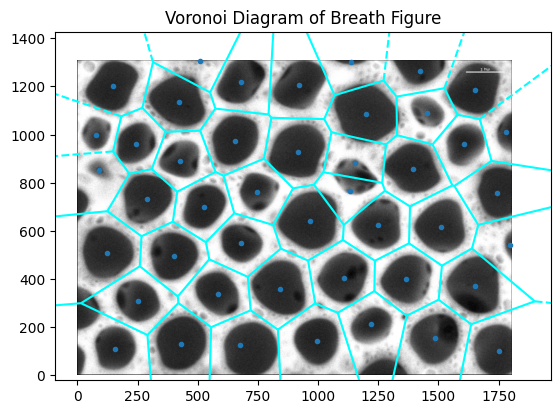

In [29]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# Compute Voronoi Tessellation
vor = Voronoi(centroids)

# Plot Voronoi Diagram
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='cyan', line_width=1.5)
plt.title('Voronoi Diagram of Breath Figure')
plt.show()


## Analyze Voronoi Cell Shapes

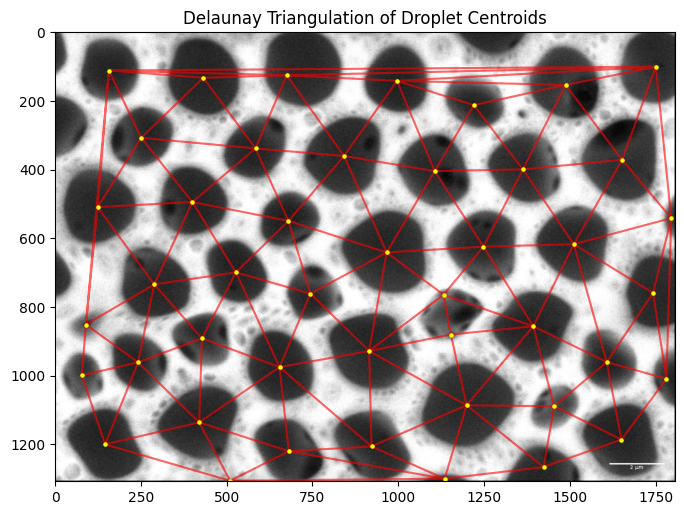

In [30]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# Load SEM Image
# Preprocess Image (assuming previous steps are done and centroids are detected)
# This part assumes that centroids are already identified, e.g., using contours or other method

# Example centroid array (replace with actual centroids)
# centroids = np.array([[100, 150], [200, 250], [300, 350], ...])

# Compute Delaunay Triangulation (corrected to use centroids as (x, y))
tri = Delaunay(centroids)

# Plotting the Image with Delaunay Triangulation
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap='gray')
ax.triplot(centroids[:, 0], centroids[:, 1], tri.simplices, color='red', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='yellow', s=5)
plt.title('Delaunay Triangulation of Droplet Centroids')
plt.show()


## Quantitative Metrics

Hexagonality Ratio: 0.41


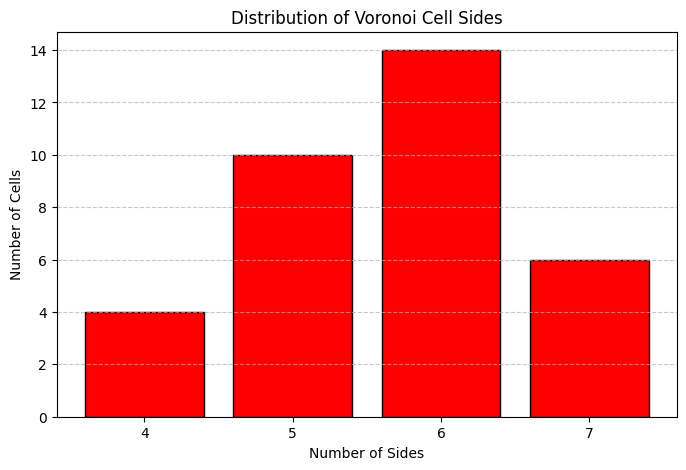

In [31]:
import networkx as nx
import matplotlib.pyplot as plt

# Construct Graph from Voronoi
graph = nx.Graph()
for i, region in enumerate(vor.regions):
    if -1 in region or len(region) == 0:
        continue
    graph.add_node(i, sides=len(region))

# Extract Number of Hexagonal Cells
hexagonal_cells = [n for n, attr in graph.nodes(data=True) if attr['sides'] == 6]
hexagonality_ratio = len(hexagonal_cells) / len(graph.nodes)

print(f'Hexagonality Ratio: {hexagonality_ratio:.2f}')

# Count the number of cells for each number of sides
side_counts = {}
for n, attr in graph.nodes(data=True):
    sides = attr['sides']
    if sides in side_counts:
        side_counts[sides] += 1
    else:
        side_counts[sides] = 1

# Sort the sides for better visualization
sorted_sides = sorted(side_counts.keys())

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(sorted_sides, [side_counts[s] for s in sorted_sides], color='red', edgecolor='black')
plt.xlabel('Number of Sides')
plt.ylabel('Number of Cells')
plt.title('Distribution of Voronoi Cell Sides')
plt.xticks(sorted_sides)  # Ensure all side numbers are shown on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

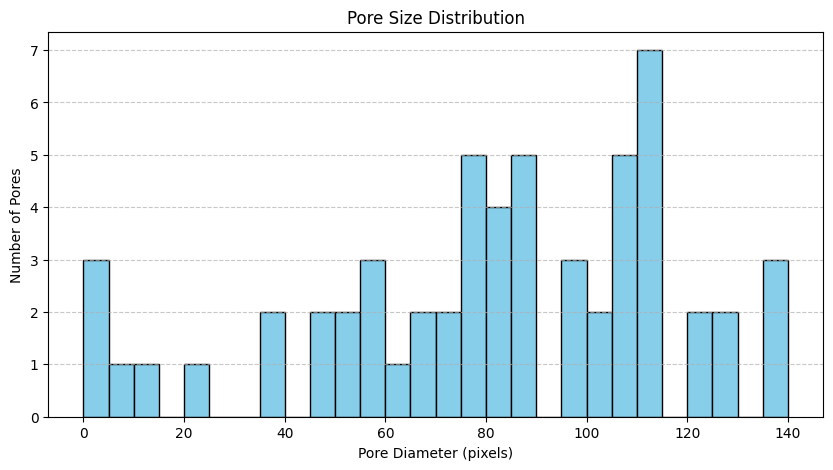

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('sample2A.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Check the file path.")

# Step 1: Preprocess the Image (Thresholding and Cleaning)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cleaned_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Step 2: Find Contours of Pores
contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Calculate Pore Diameters
pore_diameters = []
for contour in contours:
    area = cv2.contourArea(contour)
    equivalent_diameter = 2 * np.sqrt(area / np.pi)  # Diameter of a circle with the same area
    pore_diameters.append(equivalent_diameter)

# Step 4: Bin the Pore Diameters for the Bar Chart
# Define bin edges (adjust based on your pore size range)
bin_edges = np.arange(0, max(pore_diameters) + 5, 5)  # Bins of 5 units (e.g., pixels)
hist, bin_edges = np.histogram(pore_diameters, bins=bin_edges)

# Step 5: Plot the Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(bin_edges[:-1], hist, width=5, align='edge', color='skyblue', edgecolor='black')
plt.xlabel('Pore Diameter (pixels)')
plt.ylabel('Number of Pores')
plt.title('Pore Size Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()